1. Найти или сгенерировать набор данных для бинарной классификации графов.
2. Реализовать функцию shortest_path_kernel(train_graphs, test_graphs), которая принимает тренировочный и тестовые наборы, а возвращает пару K_train, K_test

  * Опишите графы с помощью вектора из количества кратчайших путей различной длины
  * Для вычисления длин кратчайших путей можно использовать nx.shortest_path_length(G)
  * Ядровая функция для сравнения двух графов - скалярное произведение их двух векторов
  * K_train - матрица из ядровых функций для сравнения тренировочных графов между собой
  * K_test - матрица из ядровых функций для сравнения тестовых графов с тренировочными

3. Используя реализованное ядро обучите модель SVC, подберите гиперпараметры, вычислите различные метрики качества
4. (+5 баллов) Также реализовать Weisfeiler-Lehman Kernel и обучить классификатор с ним, сравнить результаты.

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from collections import Counter, defaultdict
import random

# Генерируем синтетический датасет из двух классов графов со схожей структурой,

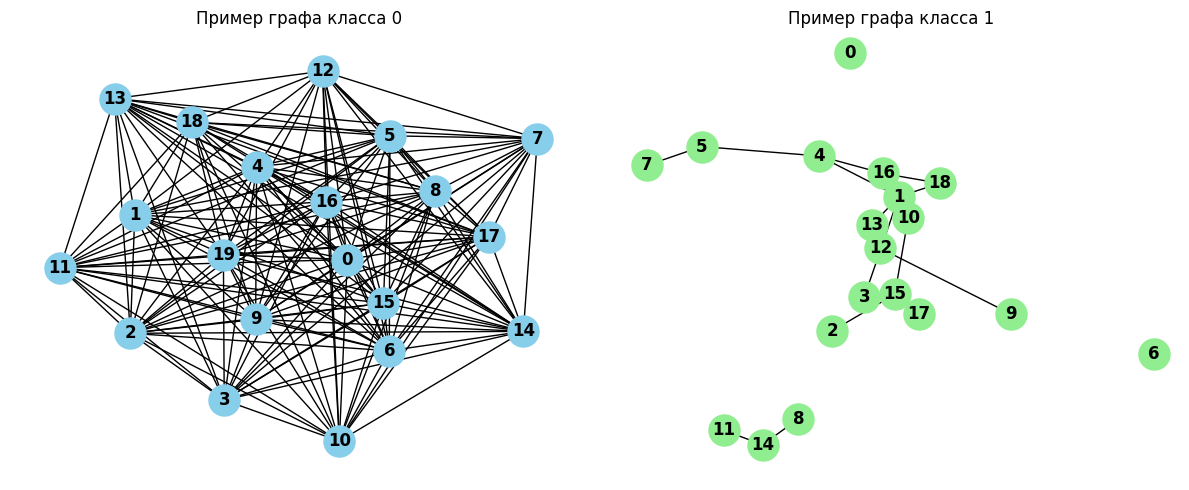

Размер обучающей выборки: 160 графов
Размер тестовой выборки: 40 графов
Распределение классов в обучающей выборке: Counter({np.int64(1): 84, np.int64(0): 76})
Распределение классов в тестовой выборке: Counter({np.int64(1): 21, np.int64(0): 19})


In [14]:

def generate_dataset(num_samples=100, max_nodes=15):
    graphs = []
    labels = []

    for _ in range(num_samples):
        # Класс 0: Графы с низкой плотностью (деревья или почти деревья)
        if np.random.rand() < 0.5:
            n = np.random.randint(5, max_nodes+1)  # Случайное число узлов
            G = nx.gnm_random_graph(n, n-1 + np.random.randint(0, 2))  # Граф с n узлами и n-1 или n рёбрами
            labels.append(0)

        # Класс 1: Графы с высокой плотностью (почти полные графы)
        else:
            n = np.random.randint(5, max_nodes+1)
            max_edges = n*(n-1)//2  # Максимальное возможное число рёбер
            m = max_edges - np.random.randint(0, n)  # Число рёбер близко к максимальному
            G = nx.gnm_random_graph(n, m)
            labels.append(1)

        for u, v in G.edges():
            G.edges[u, v]['weight'] = np.random.rand()
        graphs.append(G)

    return graphs, np.array(labels)

graphs, labels = generate_dataset(200, 20)


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
G0 = graphs[0]  # Пример графа класса 0
pos0 = nx.spring_layout(G0, seed=42)
nx.draw(G0, pos0, with_labels=True, node_color='skyblue', node_size=500, font_weight='bold')
plt.title("Пример графа класса 0")

plt.subplot(1, 2, 2)
G1 = graphs[70]  # Пример графа класса 1
pos1 = nx.spring_layout(G1, seed=42)
nx.draw(G1, pos1, with_labels=True, node_color='lightgreen', node_size=500, font_weight='bold')
plt.title("Пример графа класса 1")

plt.tight_layout()
plt.show()

# Разделяем данные на обучающую и тестовую выборки
train_graphs, test_graphs, train_labels, test_labels = train_test_split(
    graphs, labels, test_size=0.2, random_state=42, stratify=labels)

print(f"Размер обучающей выборки: {len(train_graphs)} графов")
print(f"Размер тестовой выборки: {len(test_graphs)} графов")
print(f"Распределение классов в обучающей выборке: {Counter(train_labels)}")
print(f"Распределение классов в тестовой выборке: {Counter(test_labels)}")

# Реализация функции shortest_path_kernel


Форма K_train: (160, 160)
Форма K_test: (40, 160)


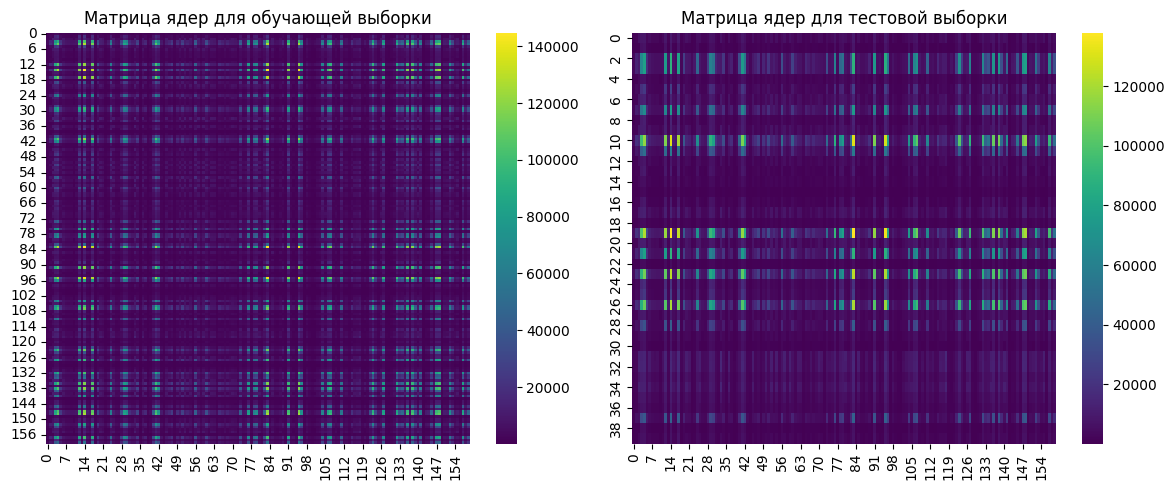

In [16]:

def graph_to_shortest_path_vector(G, max_length=10):
    path_lengths = dict(nx.all_pairs_shortest_path_length(G))

    path_counts = np.zeros(max_length + 1)

    for source in path_lengths:
        for target in path_lengths[source]:
            length = path_lengths[source][target]
            if length <= max_length:
                path_counts[length] += 1

    return path_counts

def shortest_path_kernel(train_graphs, test_graphs, max_length=10):
    train_vectors = np.array([graph_to_shortest_path_vector(G, max_length) for G in train_graphs])
    test_vectors = np.array([graph_to_shortest_path_vector(G, max_length) for G in test_graphs])

    K_train = np.dot(train_vectors, train_vectors.T)
    K_test = np.dot(test_vectors, train_vectors.T)

    return K_train, K_test

K_train, K_test = shortest_path_kernel(train_graphs, test_graphs)

print("Форма K_train:", K_train.shape)
print("Форма K_test:", K_test.shape)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(K_train, cmap='viridis')
plt.title("Матрица ядер для обучающей выборки")

plt.subplot(1, 2, 2)
sns.heatmap(K_test, cmap='viridis')
plt.title("Матрица ядер для тестовой выборки")

plt.tight_layout()
plt.show()


# Обучение SVC модели и оценка качества

Лучшие параметры: {'C': 0.1, 'class_weight': None, 'kernel': 'precomputed'}
Лучшая кросс-валидационная точность: 0.98125

Результаты на тестовой выборке (Shortest Path Kernel):
Точность (Accuracy): 0.9750
Точность (Precision): 1.0000
Полнота (Recall): 0.9524
F1-мера: 0.9756


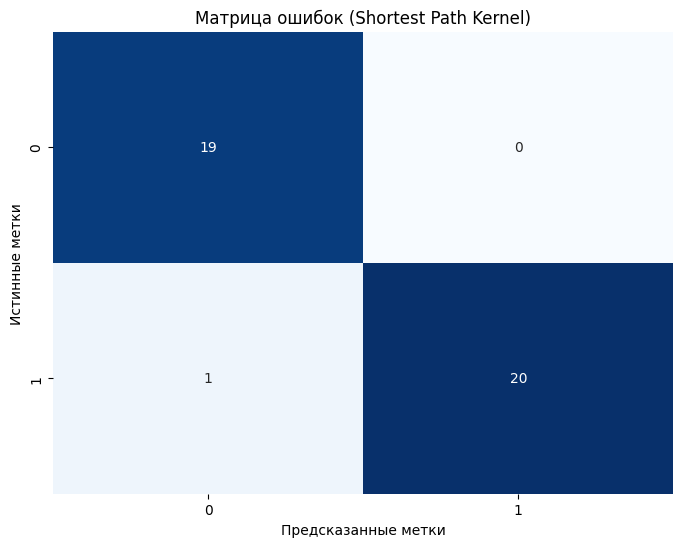

In [17]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['precomputed'],
    'class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(
    SVC(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(K_train, train_labels)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая кросс-валидационная точность:", grid_search.best_score_)

best_model = grid_search.best_estimator_
best_model.fit(K_train, train_labels)

test_predictions = best_model.predict(K_test)

accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)

print("\nРезультаты на тестовой выборке (Shortest Path Kernel):")
print(f"Точность (Accuracy): {accuracy:.4f}")
print(f"Точность (Precision): {precision:.4f}")
print(f"Полнота (Recall): {recall:.4f}")
print(f"F1-мера: {f1:.4f}")

cm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок (Shortest Path Kernel)')
plt.show()


 # Реализация Shortest Path Kernel

In [18]:
def shortest_path_kernel(train_graphs, test_graphs):
    def get_path_length_hist(G):
        path_lengths = dict(nx.shortest_path_length(G))

        all_lengths = []
        for source in path_lengths:
            for target in path_lengths[source]:
                if source != target:
                    all_lengths.append(path_lengths[source][target])

        max_length = max(all_lengths) if all_lengths else 0
        hist = np.zeros(max_length + 1)
        for length in all_lengths:
            hist[length] += 1

        return hist

    train_features = [get_path_length_hist(g) for g in train_graphs]
    test_features = [get_path_length_hist(g) for g in test_graphs]

    max_train_len = max(len(f) for f in train_features)
    max_test_len = max(len(f) for f in test_features)
    max_len = max(max_train_len, max_test_len)

    for i in range(len(train_features)):
        if len(train_features[i]) < max_len:
            train_features[i] = np.pad(train_features[i], (0, max_len - len(train_features[i])))

    for i in range(len(test_features)):
        if len(test_features[i]) < max_len:
            test_features[i] = np.pad(test_features[i], (0, max_len - len(test_features[i])))

    K_train = np.zeros((len(train_graphs), len(train_graphs)))
    K_test = np.zeros((len(test_graphs), len(train_graphs)))

    for i in range(len(train_graphs)):
        for j in range(len(train_graphs)):
            K_train[i, j] = np.dot(train_features[i], train_features[j])

    for i in range(len(test_graphs)):
        for j in range(len(train_graphs)):
            K_test[i, j] = np.dot(test_features[i], train_features[j])

    return K_train, K_test

K_train_sp, K_test_sp = shortest_path_kernel(train_graphs, test_graphs)

print("# Размерность K_train:", K_train_sp.shape)
print("# Размерность K_test:", K_test_sp.shape)


# Размерность K_train: (160, 160)
# Размерность K_test: (40, 160)


# Обучение SVM с использованием ядра кратчайших путей и оценка качества

In [20]:
def train_kernel_svm(K_train, K_test, train_labels, test_labels):
    param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
    svm = SVC(kernel='precomputed')

    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(K_train, train_labels)

    best_svm = grid_search.best_estimator_
    print(f"# Лучшее значение C: {grid_search.best_params_['C']}")

    test_pred = best_svm.predict(K_test)

    accuracy = accuracy_score(test_labels, test_pred)
    precision = precision_score(test_labels, test_pred)
    recall = recall_score(test_labels, test_pred)
    f1 = f1_score(test_labels, test_pred)
    conf_matrix = confusion_matrix(test_labels, test_pred)

    print("\n# Метрики качества для Shortest Path Kernel:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("\n# Матрица ошибок:")
    print(conf_matrix)

    return best_svm, test_pred, accuracy, precision, recall, f1

svm_sp, test_pred_sp, accuracy_sp, precision_sp, recall_sp, f1_sp = train_kernel_svm(
    K_train_sp, K_test_sp, train_labels, test_labels
)

# Лучшее значение C: 0.01

# Метрики качества для Shortest Path Kernel:
Accuracy: 0.9750
Precision: 1.0000
Recall: 0.9524
F1-score: 0.9756

# Матрица ошибок:
[[19  0]
 [ 1 20]]


# Реализация Weisfeiler-Lehman Kernel

Вычисляем ядра Weisfeiler-Lehman...
Форма WL K_train: (160, 160)
Форма WL K_test: (40, 160)


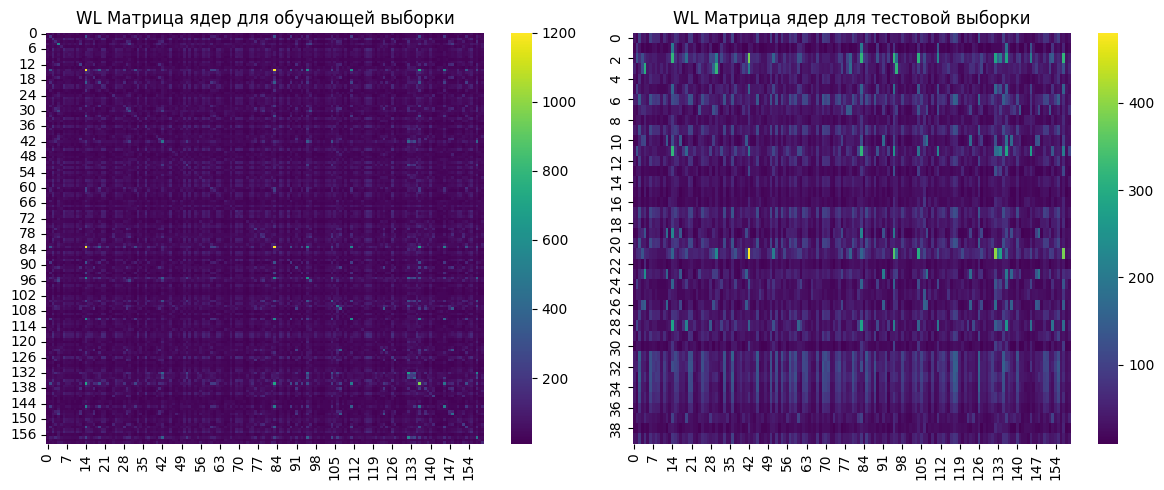

In [22]:
def weisfeiler_lehman_hash(G, num_iterations=3):
    labels = {node: str(G.degree(node)) for node in G.nodes()}

    label_history = {0: labels.copy()}

    for i in range(1, num_iterations + 1):
        new_labels = {}

        for node in G.nodes():
            neighbor_labels = [labels[neighbor] for neighbor in G.neighbors(node)]
            neighbor_labels.sort()

            new_label = labels[node] + "_" + "_".join(neighbor_labels)
            new_labels[node] = new_label

        unique_labels = sorted(set(new_labels.values()))
        label_mapping = {label: str(idx) for idx, label in enumerate(unique_labels)}

        labels = {node: label_mapping[new_labels[node]] for node in G.nodes()}

        label_history[i] = labels.copy()

    return label_history

def wl_kernel(G1, G2, num_iterations=3):
    G1_history = weisfeiler_lehman_hash(G1, num_iterations)
    G2_history = weisfeiler_lehman_hash(G2, num_iterations)

    kernel_value = 0

    for i in range(num_iterations + 1):
        G1_labels = Counter(G1_history[i].values())
        G2_labels = Counter(G2_history[i].values())

        iteration_kernel = 0
        for label in set(G1_labels.keys()) & set(G2_labels.keys()):
            iteration_kernel += G1_labels[label] * G2_labels[label]

        kernel_value += iteration_kernel

    return kernel_value

def weisfeiler_lehman_kernel(train_graphs, test_graphs, num_iterations=3):
    n_train = len(train_graphs)
    n_test = len(test_graphs)

    K_train = np.zeros((n_train, n_train))
    K_test = np.zeros((n_test, n_train))

    for i in range(n_train):
        for j in range(i + 1):
            kernel_val = wl_kernel(train_graphs[i], train_graphs[j], num_iterations)
            K_train[i, j] = kernel_val
            K_train[j, i] = kernel_val

    for i in range(n_test):
        for j in range(n_train):
            K_test[i, j] = wl_kernel(test_graphs[i], train_graphs[j], num_iterations)

    return K_train, K_test

print("Вычисляем ядра Weisfeiler-Lehman...")
wl_K_train, wl_K_test = weisfeiler_lehman_kernel(train_graphs, test_graphs, num_iterations=2)

print("Форма WL K_train:", wl_K_train.shape)
print("Форма WL K_test:", wl_K_test.shape)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(wl_K_train, cmap='viridis')
plt.title("WL Матрица ядер для обучающей выборки")

plt.subplot(1, 2, 2)
sns.heatmap(wl_K_test, cmap='viridis')
plt.title("WL Матрица ядер для тестовой выборки")

plt.tight_layout()
plt.show()


# Подбираем гиперпараметры с помощью GridSearchCV для WL ядра

Лучшие параметры (WL): {'C': 0.1, 'class_weight': None, 'kernel': 'precomputed'}
Лучшая кросс-валидационная точность (WL): 1.0

Результаты на тестовой выборке (Weisfeiler-Lehman Kernel):
Точность (Accuracy): 1.0000
Точность (Precision): 1.0000
Полнота (Recall): 1.0000
F1-мера: 1.0000


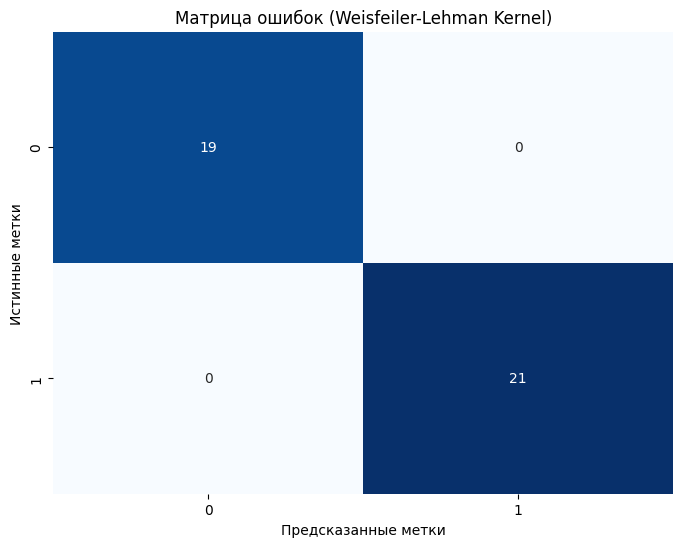

In [23]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['precomputed'],
    'class_weight': [None, 'balanced']
}

wl_grid_search = GridSearchCV(
    SVC(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

wl_grid_search.fit(wl_K_train, train_labels)

print("Лучшие параметры (WL):", wl_grid_search.best_params_)
print("Лучшая кросс-валидационная точность (WL):", wl_grid_search.best_score_)

wl_best_model = wl_grid_search.best_estimator_
wl_best_model.fit(wl_K_train, train_labels)

wl_test_predictions = wl_best_model.predict(wl_K_test)

wl_accuracy = accuracy_score(test_labels, wl_test_predictions)
wl_precision = precision_score(test_labels, wl_test_predictions)
wl_recall = recall_score(test_labels, wl_test_predictions)
wl_f1 = f1_score(test_labels, wl_test_predictions)

print("\nРезультаты на тестовой выборке (Weisfeiler-Lehman Kernel):")
print(f"Точность (Accuracy): {wl_accuracy:.4f}")
print(f"Точность (Precision): {wl_precision:.4f}")
print(f"Полнота (Recall): {wl_recall:.4f}")
print(f"F1-мера: {wl_f1:.4f}")

wl_cm = confusion_matrix(test_labels, wl_test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(wl_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок (Weisfeiler-Lehman Kernel)')
plt.show()

# Сравнение результатов двух ядер

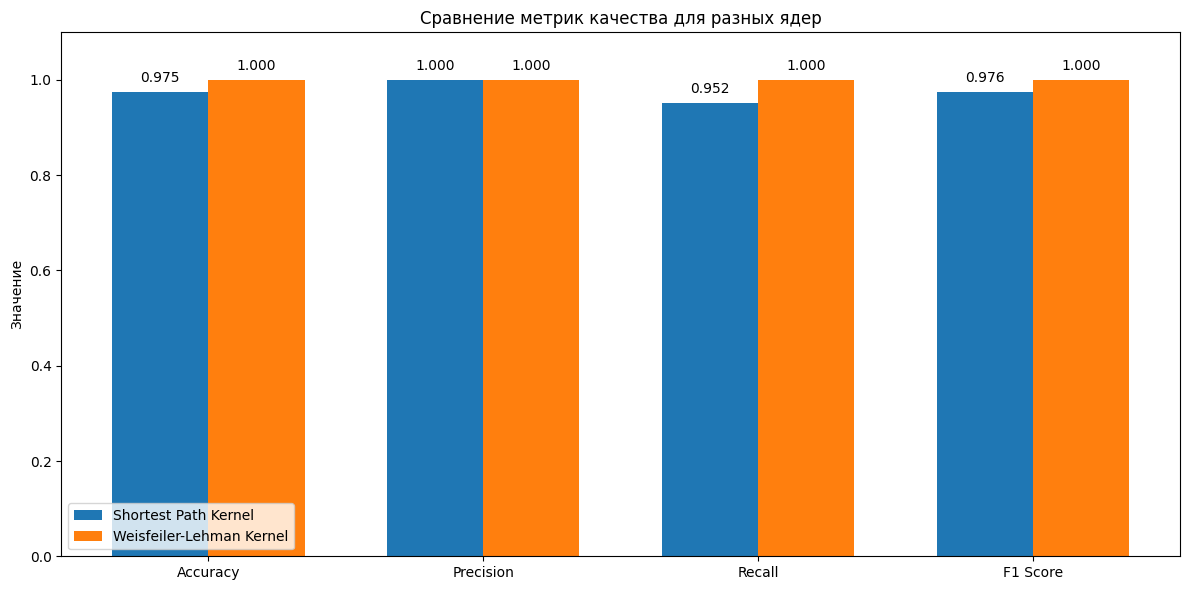

In [25]:
comparison_data = {
    'Kernel': ['Shortest Path', 'Weisfeiler-Lehman'],
    'Accuracy': [accuracy, wl_accuracy],
    'Precision': [precision, wl_precision],
    'Recall': [recall, wl_recall],
    'F1 Score': [f1, wl_f1]
}

plt.figure(figsize=(12, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, [comparison_data[m][0] for m in metrics], width, label='Shortest Path Kernel')
plt.bar(x + width/2, [comparison_data[m][1] for m in metrics], width, label='Weisfeiler-Lehman Kernel')

plt.ylabel('Значение')
plt.title('Сравнение метрик качества для разных ядер')
plt.xticks(x, metrics)
plt.ylim(0, 1.1)
plt.legend()

for i, m in enumerate(metrics):
    plt.text(i - width/2, comparison_data[m][0] + 0.02, f'{comparison_data[m][0]:.3f}', ha='center')
    plt.text(i + width/2, comparison_data[m][1] + 0.02, f'{comparison_data[m][1]:.3f}', ha='center')

plt.tight_layout()
plt.show()

Видим, что ядро Вейсфейлера-Лемана превосходит ядро кратчайших путей для классификации графов разной плотности. WL-ядро достигло идеальных показателей по всем метрикам (точность, полнота, F1-мера), что свидетельствует о его эффективности в распознавании структурных особенностей графов. Ядро кратчайших путей также показало высокие результаты (0.975 по точности), но уступает по полноте (0.952), что указывает на его меньшую способность идентифицировать все графы с высокой плотностью. Для задач классификации графов на основе структурных свойств ядро Вейсфейлера-Лемана представляется оптимальным выбором.